In [ ]:
!pip3 install influxdb-client
!pip3 install tensorflow
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install scalecast
!pip3 install seaborn
!pip3 install keras
!pip3 install darts
# brew install libomp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.1/744.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 28.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.warnings import MissingPivotFunction
from sklearn.model_selection import train_test_split
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
from darts import TimeSeries
import seaborn as sns
import time
import warnings
sns.set(rc={'figure.figsize':(25,8)})

In [ ]:
# Reading data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "energy")
  |> range(start: -2y)
  |> filter(fn: (r) => r._measurement == "energy_production")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.head()

Time taken to read the data is :  26.233875036239624


,result,table,_start,_stop,_time,_measurement,region,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
0,_result,0,2022-02-03 10:50:44.410091+00:00,2024-02-03 22:50:44.410091+00:00,2022-02-03 11:00:00+00:00,energy_production,DE,1183.50,3290.75,2496.25,997.00,1436.50,94.00,49.00,456.75,2505.50,272.75,1292.50,4177.75
1,_result,0,2022-02-03 10:50:44.410091+00:00,2024-02-03 22:50:44.410091+00:00,2022-02-03 11:15:00+00:00,energy_production,DE,1177.50,3298.25,2479.50,997.50,1425.75,102.75,49.25,456.50,2499.00,271.00,1299.75,4130.75
2,_result,0,2022-02-03 10:50:44.410091+00:00,2024-02-03 22:50:44.410091+00:00,2022-02-03 11:30:00+00:00,energy_production,DE,1176.75,3292.50,2517.00,997.25,1411.50,101.25,49.00,457.50,2513.75,281.25,1295.00,4149.00
3,_result,0,2022-02-03 10:50:44.410091+00:00,2024-02-03 22:50:44.410091+00:00,2022-02-03 11:45:00+00:00,energy_production,DE,1178.25,3297.75,2547.25,996.75,1352.75,67.00,49.00,457.75,2534.25,273.50,1278.50,4084.25
4,_result,0,2022-02-03 10:50:44.410091+00:00,2024-02-03 22:50:44.410091+00:00,2022-02-03 12:00:00+00:00,energy_production,DE,1175.50,3306.25,2752.50,996.50,1307.00,86.25,49.00,456.75,2546.25,272.00,1250.50,4026.75


In [ ]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'region']
df = df.drop(columns=columns_to_drop, inplace=False)

# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

# Sort the DataFrame by index
df = df.sort_index()

df_Sonstige_Erneuerbare = df[["Sonstige Erneuerbare"]]

print(df_Sonstige_Erneuerbare)
nan_count = df_Sonstige_Erneuerbare.isna().sum()
print("df_Sonstige_Erneuerbare shape is : ", df_Sonstige_Erneuerbare.shape)
print("Number of NaN values in 'Sonstige Erneuerbare' column:", nan_count)
df_Sonstige_Erneuerbare = df_Sonstige_Erneuerbare.ffill() # forward filling missing values
print("df_Sonstige_Erneuerbare_cleaned shape is : ", df_Sonstige_Erneuerbare.shape)

                           Sonstige Erneuerbare
_time                                          
2022-02-03 11:00:00+00:00                 49.00
2022-02-03 11:15:00+00:00                 49.25
2022-02-03 11:30:00+00:00                 49.00
2022-02-03 11:45:00+00:00                 49.00
2022-02-03 12:00:00+00:00                 49.00
...                                         ...
2024-02-03 21:00:00+00:00                   NaN
2024-02-03 21:15:00+00:00                   NaN
2024-02-03 21:30:00+00:00                   NaN
2024-02-03 21:45:00+00:00                   NaN
2024-02-03 22:00:00+00:00                   NaN

[70093 rows x 1 columns]
df_Sonstige_Erneuerbare shape is :  (70093, 1)
Number of NaN values in 'Sonstige Erneuerbare' column: Sonstige Erneuerbare    441
dtype: int64
df_Sonstige_Erneuerbare_cleaned shape is :  (70093, 1)


In [ ]:
df_Sonstige_Erneuerbare.head()

,Sonstige Erneuerbare
_time,
2022-02-03 11:00:00+00:00,49.00
2022-02-03 11:15:00+00:00,49.25
2022-02-03 11:30:00+00:00,49.00
2022-02-03 11:45:00+00:00,49.00
2022-02-03 12:00:00+00:00,49.00


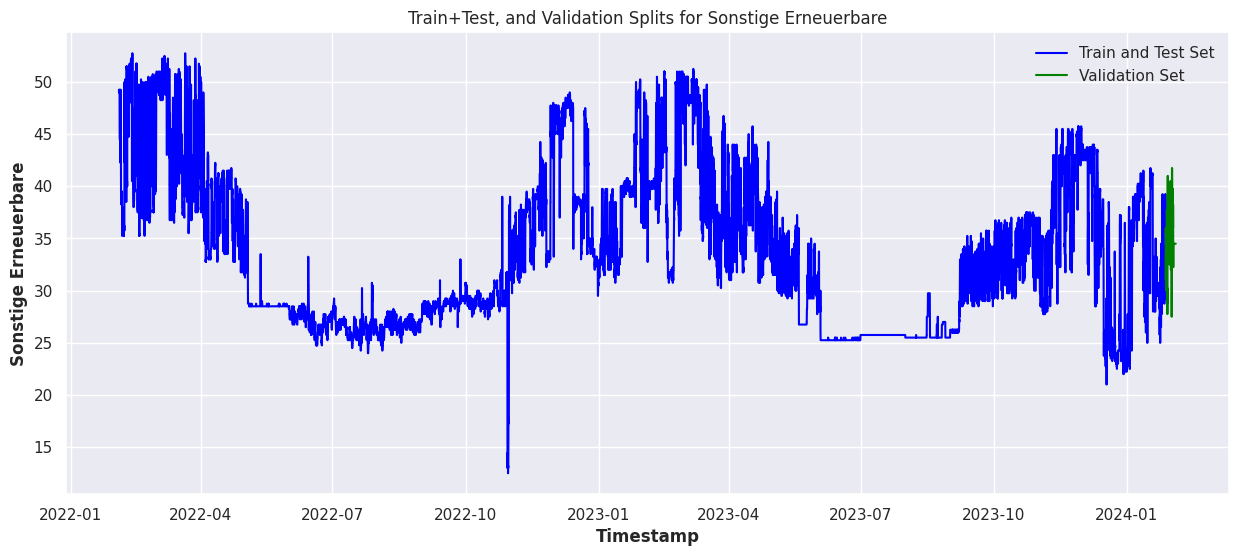

In [ ]:
# Train, Test and Validation Splits
train_test_data = df_Sonstige_Erneuerbare[:-672].copy()

# Split data into train, test, and validation sets
validation_data = df_Sonstige_Erneuerbare[-672:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(train_test_data.index, train_test_data['Sonstige Erneuerbare'], label='Train and Test Set', color='blue')
plt.plot(validation_data.index, validation_data['Sonstige Erneuerbare'], label='Validation Set', color='green')

plt.title('Train+Test, and Validation Splits for Sonstige Erneuerbare')
plt.xlabel('Timestamp')
plt.ylabel('Sonstige Erneuerbare')
plt.legend()
plt.show()

In [ ]:
#f = Forecaster(y=train_test_data.Wasserkraft,current_dates=train_test_data.index, freq='15T')
f = Forecaster(y=train_test_data['Sonstige Erneuerbare'], current_dates=train_test_data.index, freq='15T')

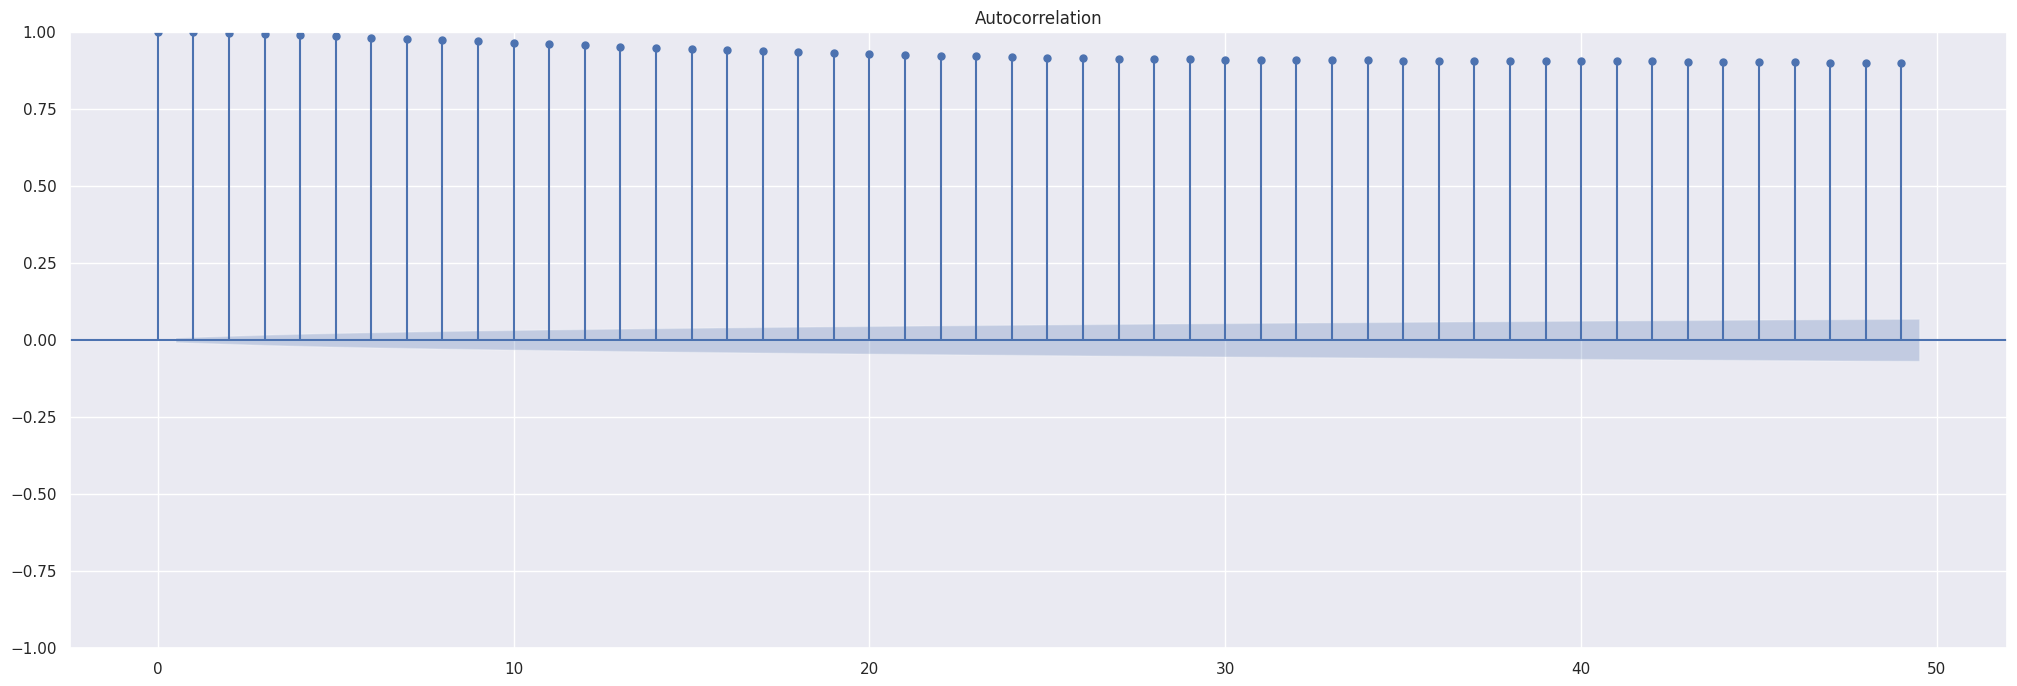

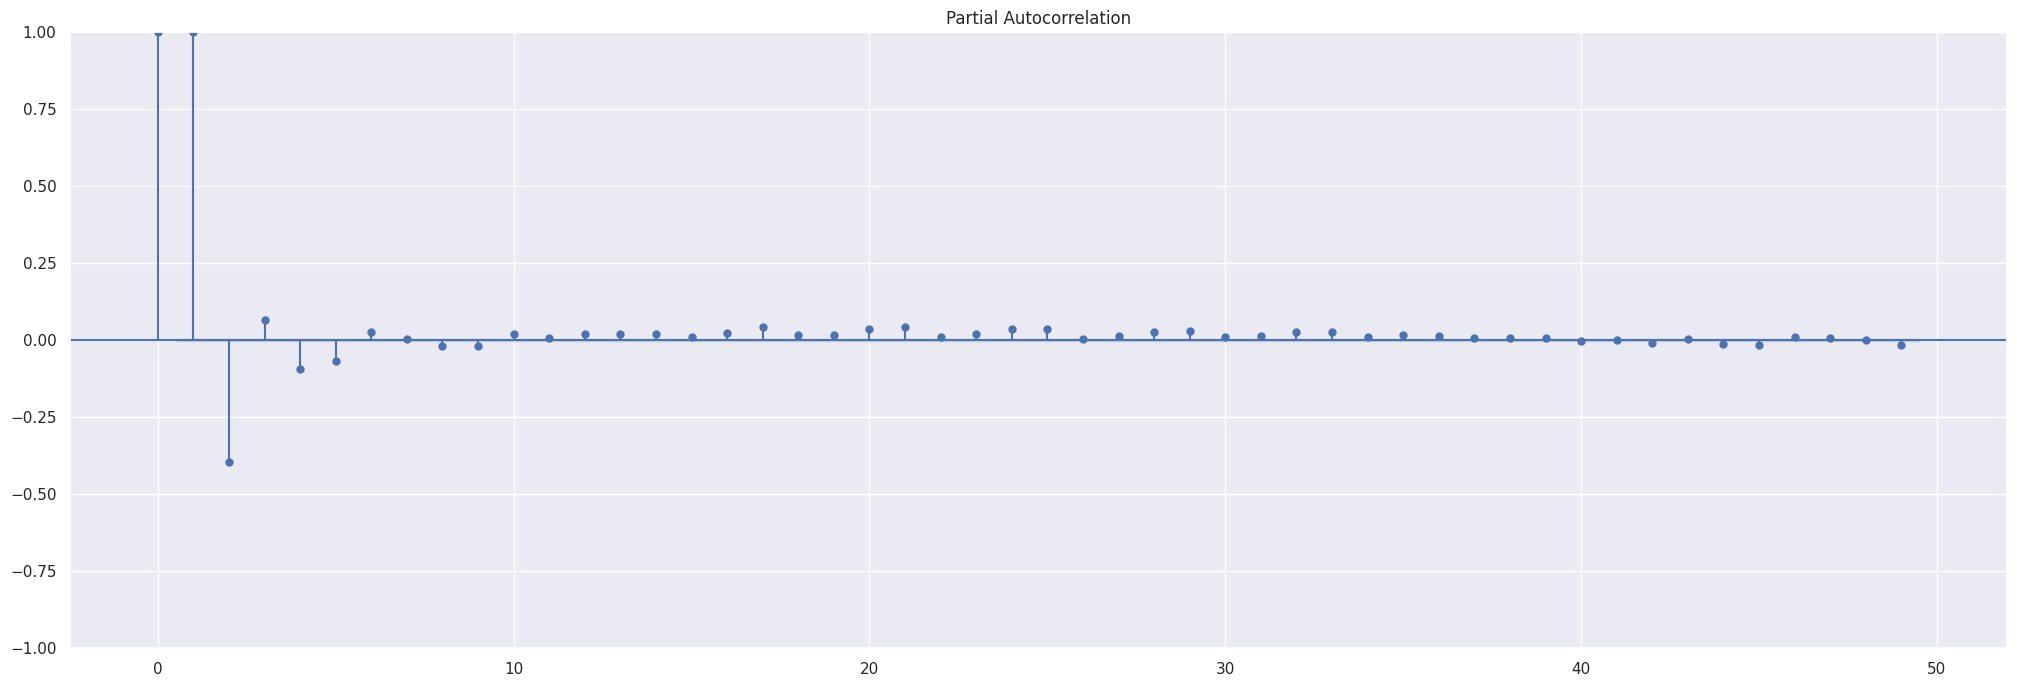

In [ ]:
f.plot_acf()
f.plot_pacf()
plt.show()

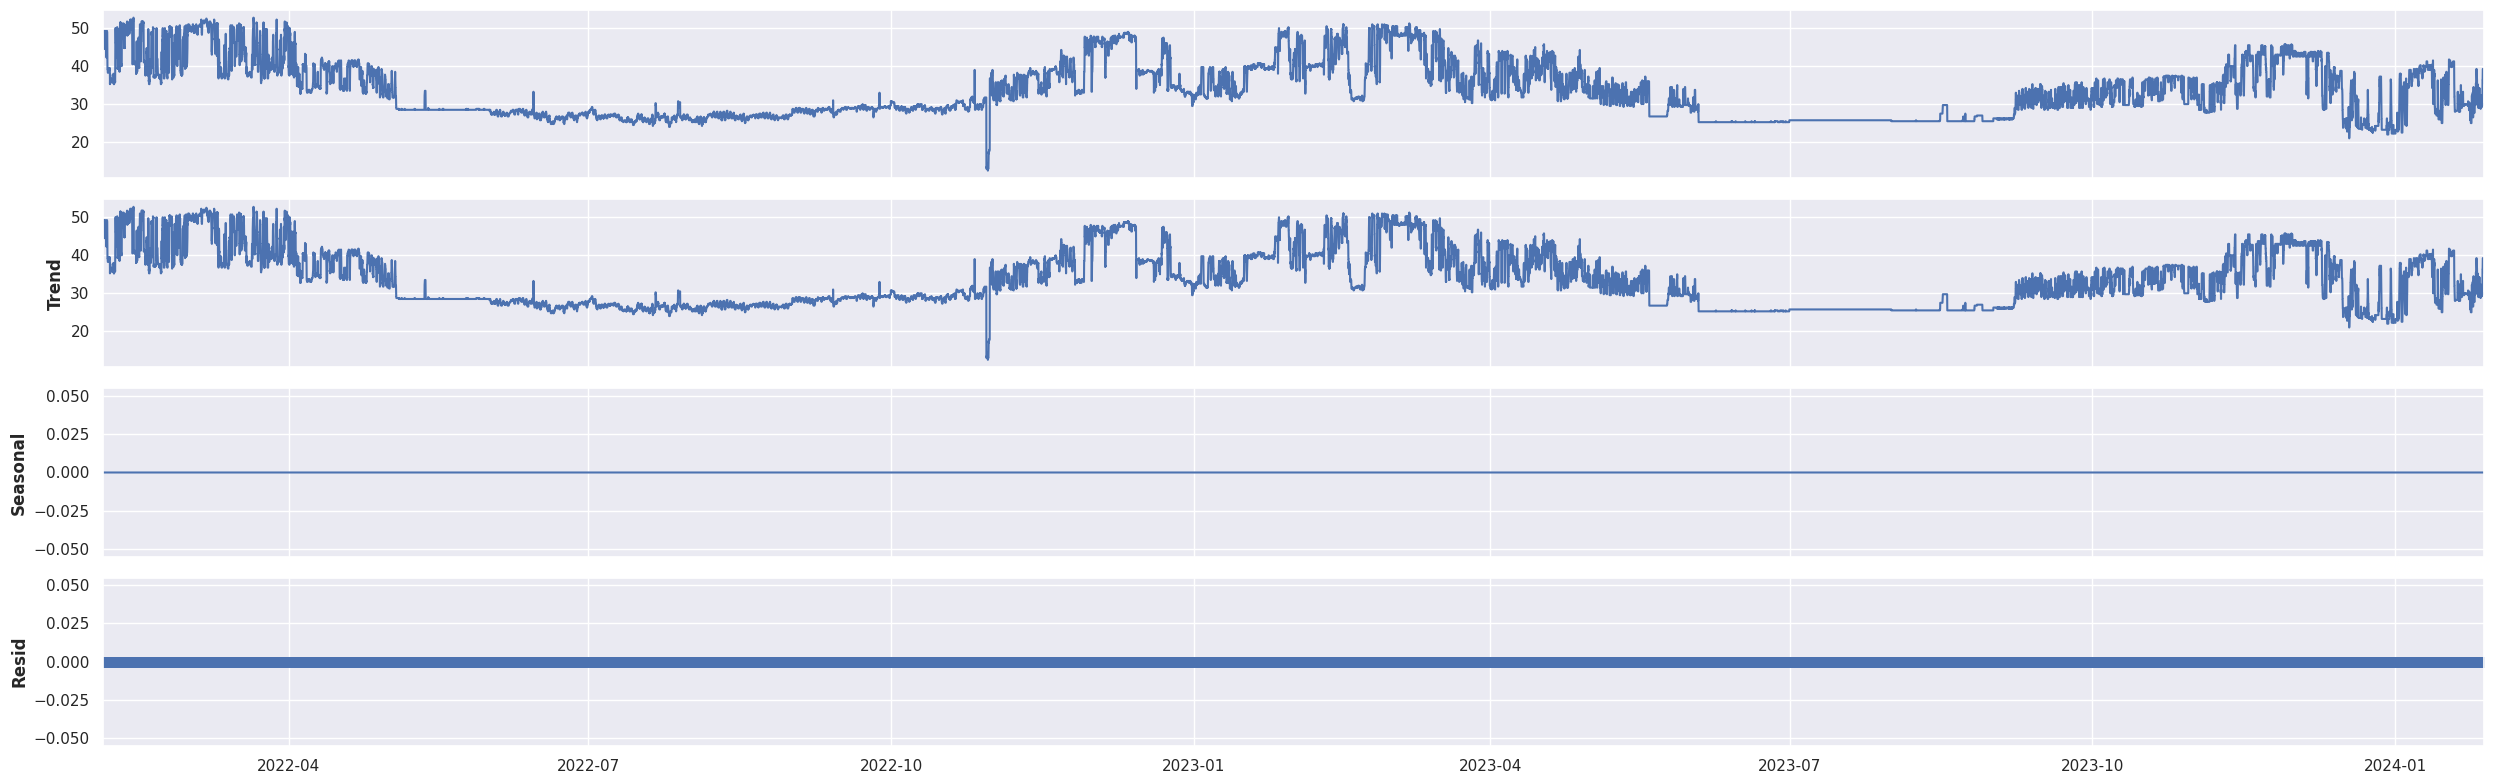

In [ ]:
# Perform seasonal decomposition
result = seasonal_decompose(train_test_data, model='additive', extrapolate_trend='freq', period=1)

# Plot the decomposed components
result.plot()
plt.show()

In [ ]:
is_stationary = f.adf_test(full_res=False)
print(is_stationary)

True


In [ ]:
f.set_test_length(0.10)

In [ ]:
f.eval_cis()

In [ ]:
f.add_time_trend()

In [ ]:
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

In [ ]:
f.generate_future_dates(1344)
f.set_estimator('lstm')

Epoch 1/25
1561/1561 [==============================] - 29s 14ms/step - loss: 0.1324 - val_loss: 0.0802
Epoch 2/25
1561/1561 [==============================] - 19s 12ms/step - loss: 0.1054 - val_loss: 0.0796
Epoch 3/25
1561/1561 [==============================] - 20s 13ms/step - loss: 0.1044 - val_loss: 0.0864
Epoch 4/25
1561/1561 [==============================] - 20s 13ms/step - loss: 0.1040 - val_loss: 0.0836
Epoch 5/25
1561/1561 [==============================] - 19s 12ms/step - loss: 0.1039 - val_loss: 0.0889
Epoch 6/25
1561/1561 [==============================] - 20s 13ms/step - loss: 0.1031 - val_loss: 0.0878
Epoch 7/25
1561/1561 [==============================] - 20s 13ms/step - loss: 0.1030 - val_loss: 0.0838
Epoch 8/25
1561/1561 [==============================] - 20s 13ms/step - loss: 0.1030 - val_loss: 0.0865
Epoch 9/25
1561/1561 [==============================] - 20s 13ms/step - loss: 0.1024 - val_loss: 0.0833
Epoch 10/25
1/1 [==============================] - 2s 2s/step


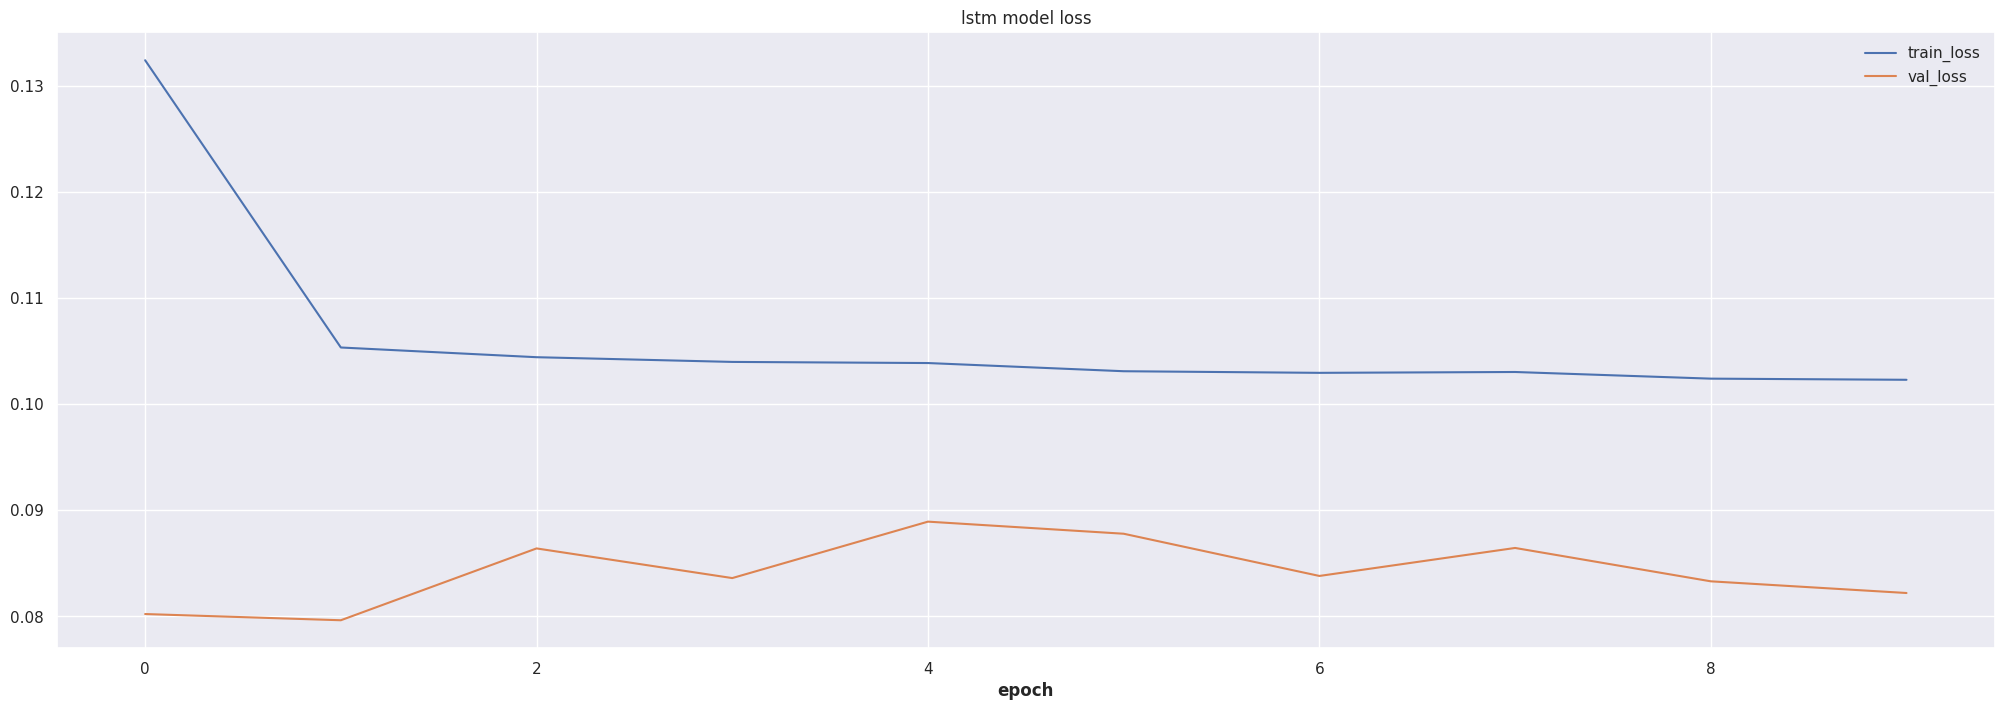

Epoch 1/25
1914/1914 [==============================] - 32s 14ms/step - loss: 0.1046 - val_loss: 0.1453
Epoch 2/25
1914/1914 [==============================] - 24s 12ms/step - loss: 0.0705 - val_loss: 0.1469
Epoch 3/25
1914/1914 [==============================] - 24s 12ms/step - loss: 0.0706 - val_loss: 0.1426
Epoch 4/25
1914/1914 [==============================] - 24s 13ms/step - loss: 0.0697 - val_loss: 0.1451
Epoch 5/25
1914/1914 [==============================] - 24s 12ms/step - loss: 0.0695 - val_loss: 0.1452
Epoch 6/25
1914/1914 [==============================] - 24s 13ms/step - loss: 0.0692 - val_loss: 0.1427
Epoch 7/25
1914/1914 [==============================] - 24s 12ms/step - loss: 0.0690 - val_loss: 0.1430
Epoch 8/25
1914/1914 [==============================] - 25s 13ms/step - loss: 0.0687 - val_loss: 0.1444
Epoch 9/25
1914/1914 [==============================] - 24s 12ms/step - loss: 0.0687 - val_loss: 0.1439
Epoch 10/25
1914/1914 [==============================] - 24s 12m

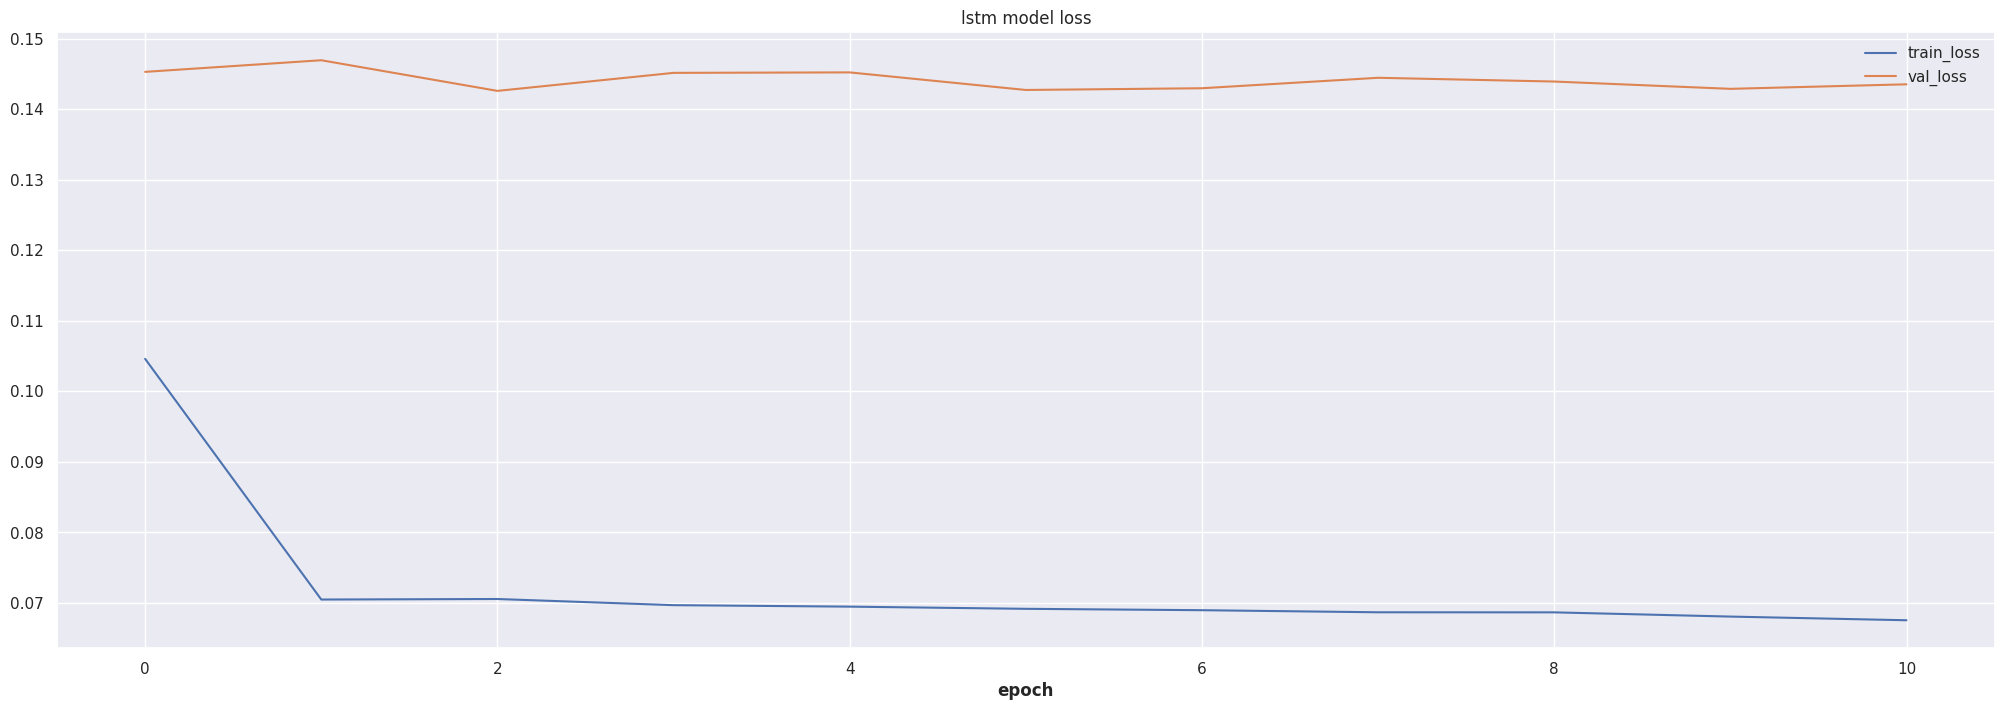

In [ ]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=25,
                  validation_split=0.1,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

Mean Absolute Error (MAE) prediction vs validation set : 3.773233182196106


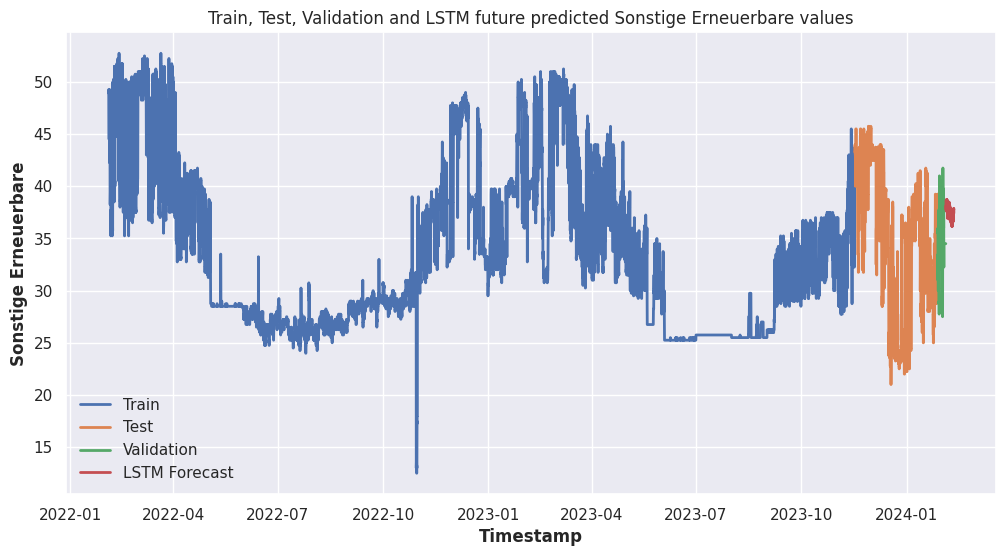

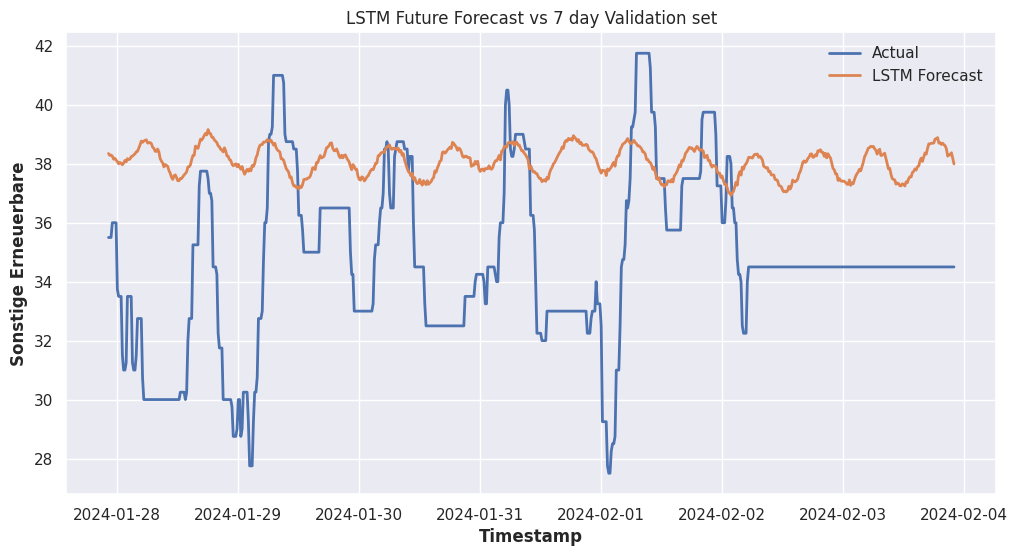

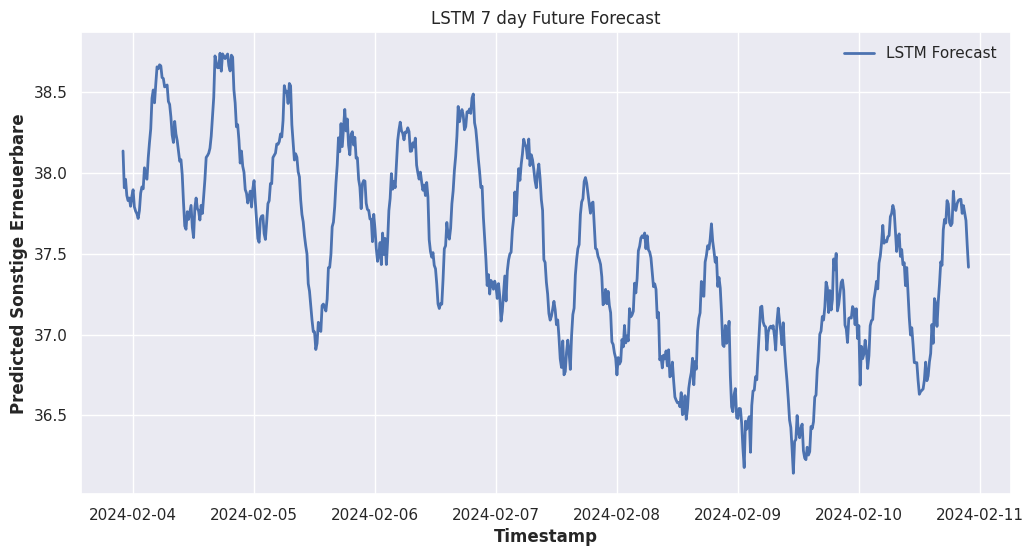

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Get future forecast values and index
lstm_default_forecasted_df = f.export('lvl_fcsts')
last_timestamp = validation_data.index[-1]
new_index = pd.date_range(start=last_timestamp, periods=672, freq='15T')
existing_index_series = pd.Series(validation_data.index)
new_index_series = pd.Series(new_index)
concatenated_series = pd.concat([existing_index_series, new_index_series])
lstm_default_forecasted_df.index = concatenated_series

# Calculate MAE
mae = mean_absolute_error(validation_data["Sonstige Erneuerbare"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
mape = mean_absolute_percentage_error(validation_data["Sonstige Erneuerbare"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
rmse = root_mean_squared_error(validation_data["Sonstige Erneuerbare"].values, lstm_default_forecasted_df["lstm_best"].values[:672])


# Add more metrics here
print(f'Mean Absolute Error (MAE) prediction vs validation set : {mae}')
print(f'Mean Absolute Percentage Error (MAPE) prediction vs validation set : {mape*100:.2f}%')
print(f'Root Mean Squared Error (RMSE) prediction vs validation set : {rmse}')


# Split train_test_data into separate train and test sets and train_index and test_index
train_index, test_index = train_test_split(train_test_data.index, test_size=0.1, shuffle=False, random_state=42)
train,test = train_test_split(train_test_data["Sonstige Erneuerbare"], test_size=0.1, shuffle=False, random_state=42)


# Plotting train+test, validation and future predictions together
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Train', linewidth=2)
plt.plot(test_index, test, label='Test', linewidth=2)
plt.plot(validation_data.index, validation_data["Sonstige Erneuerbare"], label='Validation', linewidth=2)
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Sonstige Erneuerbare')
plt.title('Train, Test, Validation and LSTM future predicted Sonstige Erneuerbare values')
plt.legend()
plt.show()

# Plotting simulated future with validation
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data["Sonstige Erneuerbare"], label='Actual', linewidth=2)
plt.plot(validation_data.index, lstm_default_forecasted_df["lstm_best"][:672], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Sonstige Erneuerbare')
plt.title('LSTM Future Forecast vs 7 day Validation set')
plt.legend()
plt.show()

# Plotting real future
plt.figure(figsize=(12, 6))
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Predicted Sonstige Erneuerbare')
plt.title('LSTM 7 day Future Forecast')
plt.legend()
plt.show()


In [ ]:
forecasted_values = lstm_default_forecasted_df["lstm_best"][672:]
forecasted_values
forecasted_values.to_csv('Sonstige_Erneuerbare_Future_7_days.csv', index_label='Timestamp', encoding='utf-8')

In [ ]:
forecasted_values_corrected = lstm_default_forecasted_df["lstm_best"][:672].values

combined_df = pd.DataFrame({
    'Timestamp': validation_data.index,
    'Actual Sonstige Erneuerbare': validation_data['Sonstige Erneuerbare'].values,
    'Forecasted Sonstige Erneuerbare': forecasted_values_corrected
})

# Export to CSV
combined_df.to_csv('Sonstige_Erneuerbare_Actual_vs_Forecasted.csv', index=False, encoding='utf-8')